Import Packages

re, numpy, and geopandas only used for one command

In [1]:
import pandas as pd
import re
import numpy as np
import geopandas as gpd
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import GeoJSONDataSource
from bokeh.palettes import Category20_20
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

In [2]:
#Read in csv of property standards violations with categories assigned
categories_test = pd.read_csv("../data/categories_test.csv")
categories = categories_test.drop(["Unnamed: 0", "request_no", "prop_apn", "prop_address", "city", "state", "prop_owner", "reported_problem", "last_activity_date", "last_activity", "last_activity_code"], axis = 1)
categories['date_recv'] = pd.to_datetime(categories['date_recv'])
categories.head(1)

date_recv      zip complaint_source status  council_district  \
0 2017-05-04  37218.0            EMAIL   DONE               1.0   

  violations_noted                                         mapped_loc  \
0       HIGH WEEDS  121 QUEENS LN\nNASHVILLE, TN 37218\n(36.213718...   

  violation_category  
0          LANDSCAPE

In [3]:
# after reading the property standards data

# To pull latitude & longitude from the mapped_loc column to two new columns,
# we first need a function to extract lat and lng

# 121 QUEENS LN\nNASHVILLE, TN 37218\n(36.213718, -86.861065)
lat_lng_pattern = re.compile(r'\((.*),\s*(.*)\)', flags=re.MULTILINE)

def extract_lat_lng(address):
    try:
        lat_lng_match = lat_lng_pattern.search(address)
        lat = float(lat_lng_match.group(1))
        lng = float(lat_lng_match.group(2))
        return (lat, lng)
    except:
        return (np.NaN, np.NaN)  #it's important that our list be exactly as long as our df

# Iterating through the mapped_loc column, we apply our function to
# extract lat/lng pairs and store them in a list of tuples.
# Then we can use a list comprehension (or loop) to iterate through the tuple
# and create out two new columns.

lat_lngs = [extract_lat_lng(location) for location in categories.loc[:, 'mapped_loc']]
categories['lat'] = [lat for lat, lng in lat_lngs]
categories['lng'] = [lng for lat, lng in lat_lngs]

In [4]:
#check to see lat lng appropriate.
categories.head(1)

date_recv      zip complaint_source status  council_district  \
0 2017-05-04  37218.0            EMAIL   DONE               1.0   

  violations_noted                                         mapped_loc  \
0       HIGH WEEDS  121 QUEENS LN\nNASHVILLE, TN 37218\n(36.213718...   

  violation_category        lat        lng  
0          LANDSCAPE  36.213718 -86.861065

In [5]:
#When mapping whole dataset, two points were far away.
#outliers = [<-90, >-83]
categories_1 = categories.drop(categories[categories["lng"]<-90].index)
categories_2 = categories_1.drop(categories_1[categories_1["lng"]>-83].index)
categories_2["violation_category"].value_counts()

WASTE                 11589
VEHICLE                9465
LANDSCAPE              7602
OTHER/MISC             2534
NO_CATEGORY            1410
SIGNAGE                 919
EXTBLD                  775
FENCING                 481
INTBLD                  302
OCCUPANCY               284
PLUMBING                165
ELECTRICAL              126
SHORT_TERM_RENTAL       108
ANIMALS/VERMIN           44
FIRE                     33
SALES                    10
ALCOHOL -- OTHER          3
ALCOHOL -- PERMITS        1
Name: violation_category, dtype: int64

In [6]:
#read in geojson with polygons outlining districts. 
#Polygon column has geometry attribute so must be read in with geopandas.
dist_df = gpd.read_file("../data/Council District Outlines (GIS).geojson")

#check columns in districts dataframe.
dist_df.head(1)

first_name                        email     res_phone     bus_phone  \
0       Nick  nick.leonardo@nashville.gov  615-509-6334  615-862-6780   

  last_name        position district  \
0  Leonardo  Council Member        1   

                                            geometry  
0  (POLYGON ((-86.90738248774342 36.3905151283193...

In [7]:
#drop all but geometry column with polygon coordinates. 
#In future can add back in other columns (district) for bokeh hover tool 
district_df = dist_df.drop(["first_name", "email", "res_phone", "bus_phone", "last_name", "position", "district"], axis = 1)
district_df.head()

geometry
0  (POLYGON ((-86.90738248774342 36.3905151283193...
1  (POLYGON ((-86.75902399986667 36.2309080000732...
2  (POLYGON ((-86.72850199989709 36.2832840002146...
3  (POLYGON ((-86.68680500011935 36.2867050001350...
4  (POLYGON ((-86.74488864807594 36.0531632050230...

In [8]:
#Downstream interactive legend in bokeh map requires each category be in its own df.
#Even though frames will be combined into one, having them separate is important for assigning each to an entry 
#in the legend and giving each category a color

WASTE = categories_2[categories_2["violation_category"].str.contains("WASTE", na = False)]
VEHICLE = categories_2[categories_2["violation_category"].str.contains("VEHICLE", na = False)]
LANDSCAPE = categories_2[categories_2["violation_category"].str.contains("LANDSCAPE", na = False)]
MISC = categories_2[categories_2["violation_category"].str.contains("OTHER/MISC", na = False)]
NO_CATEGORY = categories_2[categories_2["violation_category"].str.contains("NO_CATEGORY", na = False)]
SIGNAGE = categories_2[categories_2["violation_category"].str.contains("SIGNAGE", na = False)]
EXTBLD = categories_2[categories_2["violation_category"].str.contains("EXTBLD", na = False)]
FENCING = categories_2[categories_2["violation_category"].str.contains("FENCING", na = False)]
INTBLD = categories_2[categories_2["violation_category"].str.contains("INTBLD", na = False)]
OCCUPANCY = categories_2[categories_2["violation_category"].str.contains("OCCUPANCY", na = False)]
PLUMBING = categories_2[categories_2["violation_category"].str.contains("PLUMBING", na = False)]
ELECTRICAL = categories_2[categories_2["violation_category"].str.contains("ELECTRICAL", na = False)]
SHORT_TERM_RENTAL = categories_2[categories_2["violation_category"].str.contains("SHORT_TERM_RENTAL", na = False)]
ANIMAL = categories_2[categories_2["violation_category"].str.contains("ANIMALS/VERMIN", na = False)]
FIRE = categories_2[categories_2["violation_category"].str.contains("FIRE", na = False)]
SALES = categories_2[categories_2["violation_category"].str.contains("SALES", na = False)]
ALCOHOL_OTHER = categories_2[categories_2["violation_category"].str.contains("ALCOHOL_OTHER", na = False)]
ALCOHOL_PERMITS = categories_2[categories_2["violation_category"].str.contains("ALCOHOL_PERMITS", na = False)]
#NO_CATEGORY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1410 entries, 5 to 35827
Data columns (total 10 columns):
date_recv             1410 non-null datetime64[ns]
zip                   1407 non-null float64
complaint_source      1407 non-null object
status                1410 non-null object
council_district      1405 non-null float64
violations_noted      1410 non-null object
mapped_loc            1407 non-null object
violation_category    1410 non-null object
lat                   1377 non-null float64
lng                   1377 non-null float64
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 121.2+ KB


In [9]:
#Bokeh geo plot of violation in Davidson county. Districts are outlined and violations are color coded by category.
#The legend is interactive, which allows observing specific subsets of data by violation category.

#Convert district geopandas df to a geojson. Possibly refactor to import geojson directly instead of geopandas df first
#Convert geojson to GeoJsonDataSource that can be read by bokeh. Geopandas dfs cannot be read by bokeh, unlike regular dfs

geojson = district_df.to_json()
geo_source = GeoJSONDataSource(geojson=geojson)

#Print graphs in notebook, only need this command once, subsequent graphs will also be printed in notebook.
output_notebook()

#Create plot space and title
p = figure(plot_width=1000, plot_height=1000, title = "Property Standards Violations in Nashville by Violation Category")

#Add axis titles
p.xaxis.axis_label = "Longitude"
p.yaxis.axis_label = "Latitude"

#This makes this distric outlines. Putting it before plotting the points makes it so that it is layered behind points.
#'xs' and 'ys' come from separating the coordinates during converting to geojsondatasource (I think)
p.patches('xs', 'ys', fill_alpha=0, source=geo_source, line_color = "black")

#Loops over each df created before and zips it with a title for the df and a color from the Category20_20 palette.
for data, name, color in zip([WASTE, VEHICLE, LANDSCAPE, MISC, NO_CATEGORY, SIGNAGE, EXTBLD, FENCING, INTBLD, OCCUPANCY, 
                              PLUMBING, ELECTRICAL, SHORT_TERM_RENTAL, ANIMAL, FIRE, SALES, ALCOHOL_OTHER, 
                              ALCOHOL_PERMITS], 
                             ["WASTE", "VEHICLE", "LANDSCAPE", "MISC", "NO_CATEGORY", "SIGNAGE", "EXTBLD", "FENCING", 
                              "INTBLD", "OCCUPANCY", "PLUMBING", "ELECTRICAL", "SHORT_TERM_RENTAL", "ANIMAL", "FIRE", 
                              "SALES", "ALCOHOL_OTHER", "ALCOHOL_PERMITS"], Category20_20):
#combine all dfs into one for plotting    
    combined = pd.DataFrame(data)
#pulls lat and lng columns from combined df for plotting. lng is x, lat is y.
    p.circle(combined["lng"], combined["lat"], line_alpha = 0, color=color, size = 5, legend = name)

#Adds legend to plot, places it in the top right of the plot.
p.legend.location = "top_right"
#This is what makes the legend interactive. Clicking on the legend entry will remove associated points 
#and gray out enter in legend
p.legend.click_policy="hide"

show(p)

Loading BokehJS ...

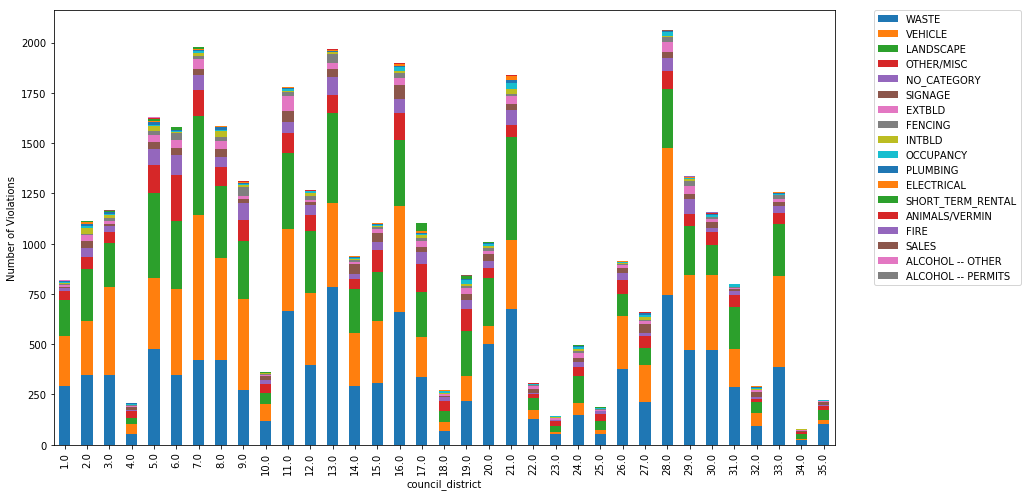

In [10]:
#Stacked bar chart showing number of violations per category in each district.

#New df that groups by council district and then violation category. 
#Then counts the number of entries in each council district 
#and breaks down the count (unstack) by violation category.
categories_3 = categories_2.groupby(['council_district', 'violation_category'])['council_district'].count().unstack('violation_category').fillna(0)

#Since df is grouped, plotting data with args kind = bar and stacked = True will subdivide based on column
categories_3[["WASTE", "VEHICLE", "LANDSCAPE", "OTHER/MISC", "NO_CATEGORY", "SIGNAGE", "EXTBLD", "FENCING", "INTBLD", "OCCUPANCY", 
     "PLUMBING", "ELECTRICAL", "SHORT_TERM_RENTAL", "ANIMALS/VERMIN", "FIRE", "SALES", "ALCOHOL -- OTHER", 
     "ALCOHOL -- PERMITS"]].plot(kind='bar', stacked=True, figsize = (14, 8))

#add legend to plot and y axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Number of Violations")

plt.show()

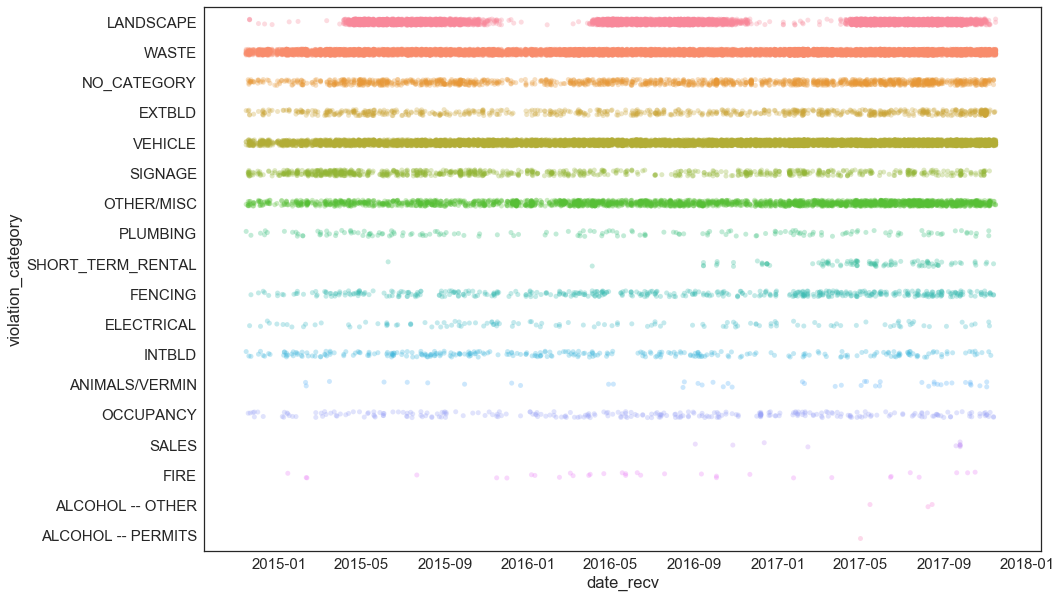

In [11]:
#Horizontal strip plot showing violations by category over time.

#Create the plot area. Using the command 'set' will create a background with gridlines by default. 
#Required for setting font
sns.set(font_scale = 1.5)
#Set background to white to essentially remove it.
sns.set_style("white")
plt.subplots(figsize=(15,10))

#Add data. Since y is categorical it will split as such, since x is continuous, it will also split as such.
#Jitter = True cause slight spreading of points so not stacked on top of each other so much. 
#Can provide int as arg but anything above 1 spreads points out too much.
#Setting alpha will allow easier visualization of points stacked on top of each other
sns.stripplot(x="date_recv", y="violation_category", data=categories_2, jitter=True, alpha = .3)

(array([  1.73890000e+04,   4.47500000e+03,   1.38700000e+03,
          5.72000000e+02,   2.11000000e+02,   1.07000000e+02,
          4.90000000e+01,   2.80000000e+01,   0.00000000e+00,
          7.00000000e+00,   8.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1.  ,   1.88,   2.76,   3.64,   4.52,   5.4 ,   6.28,   7.16,
          8.04,   8.92,   9.8 ,  10.68,  11.56,  12.44,  13.32,  14.2 ,
         15.08,  15.96,  16.84,  17.72,  18.6 ,  19.48,  20.36,  21.24,
         22.12,  23.  ]),
 <a list of 25 Patch objects>)

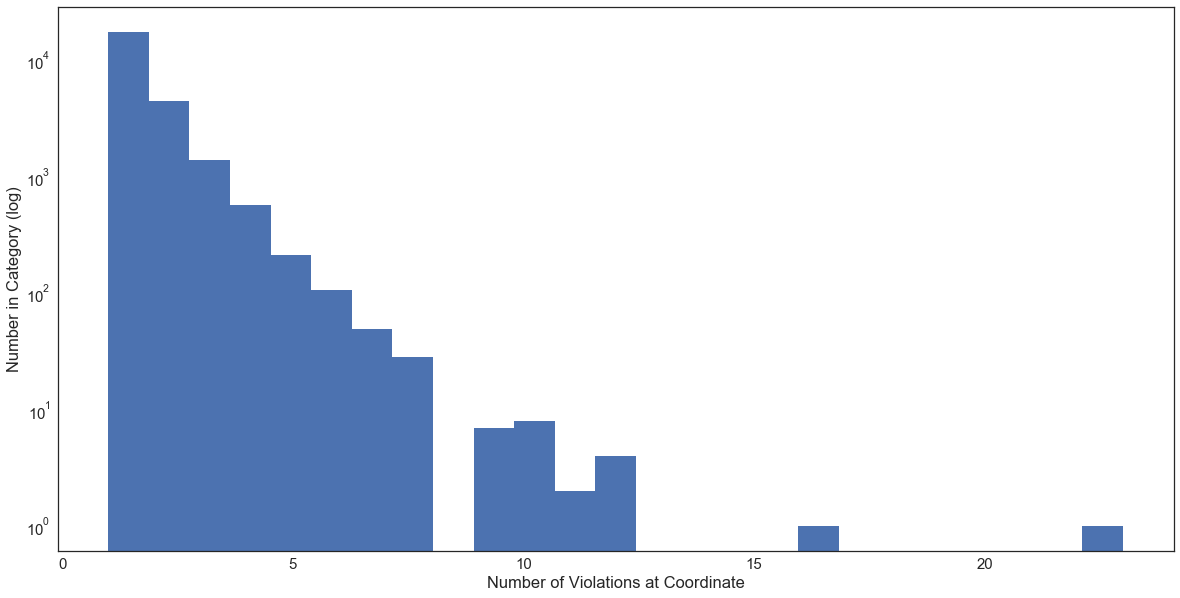

In [12]:
#Histogram showing the number of violations per coordinate.

#Group df by both lat and lng (requires both lat and lng match to be in same group), then count lenth of each group.
group_latlng = categories_2.groupby(["lat", "lng"]).agg(len)
#group_latlng["violation_category"]

#Create plot space
plt.figure(figsize=(20,10))
#Make y-axis log scale so can visualize all points more easily.
plt.yscale('log', nonposy='clip')
plt.ylabel('Number in Category (log)')
plt.xlabel('Number of Violations at Coordinate')
#Above lines need to be before plotting histogram so that it will affect the histogram.
#Set high number of bins so that different groups are not binned together, at least 23 bins.
plt.hist(group_latlng["violation_category"], bins = 25)

In [13]:
#Identify the point with highest number of violations.
group_latlng[group_latlng["violation_category"]>20]

date_recv   zip  complaint_source  status  \
lat       lng                                                     
36.051935 -86.714561         23  23.0                23      23   

                      council_district  violations_noted  mapped_loc  \
lat       lng                                                          
36.051935 -86.714561              23.0                23          23   

                      violation_category  
lat       lng                             
36.051935 -86.714561                  23

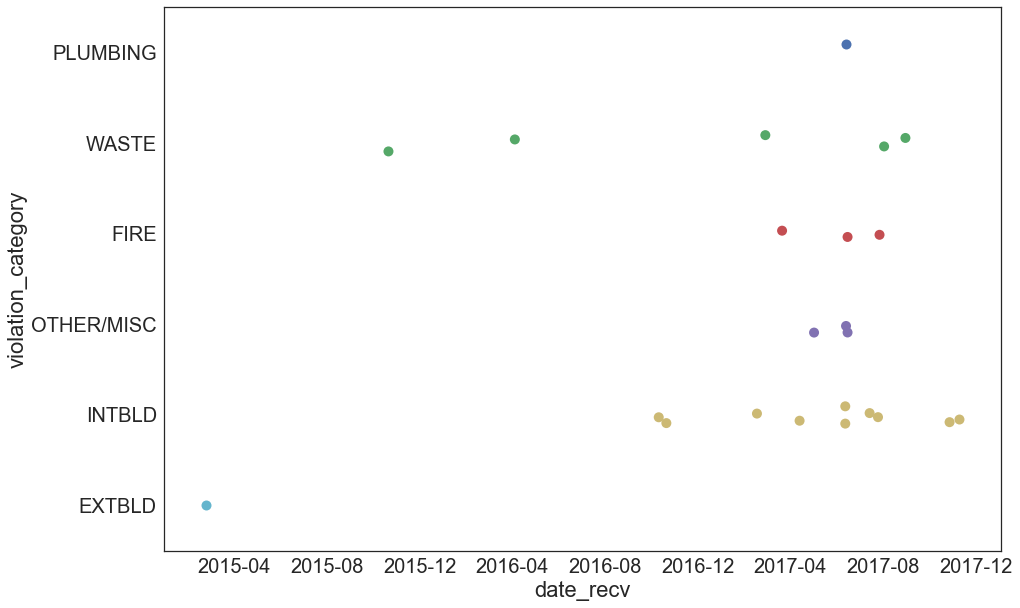

In [14]:
#New df with violations associated with specific lat lng combo. Need to specify both lat and lng, 
#otherwise pick up other points erroneously.
same_lat = categories_2[categories_2["lat"].isin([36.051935])&categories_2["lng"].isin([-86.714561])]
#same_lat

#Strip plot showing violations per category over time for point with the highest number of associated violations.
sns.set(font_scale = 2)
sns.set_style("white")
plt.subplots(figsize=(15,10))
sns.stripplot(x="date_recv", y="violation_category", data=same_lat, jitter=True, size = 10)

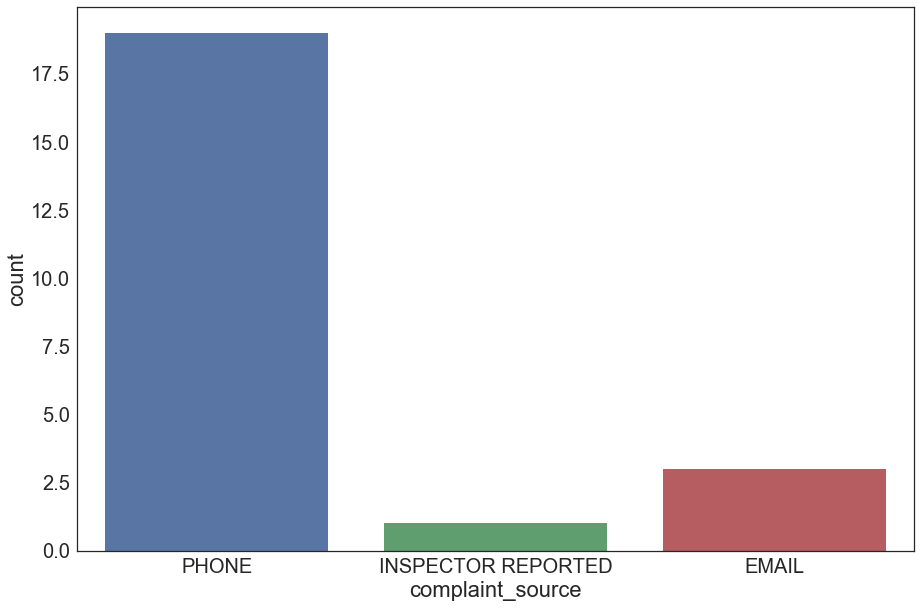

In [15]:
#Bar chart breaking down violations from single point by how it was reported.

sns.set(font_scale = 2)
sns.set_style("white")
plt.subplots(figsize=(15,10))
sns.countplot(x = "complaint_source", data = same_lat, )

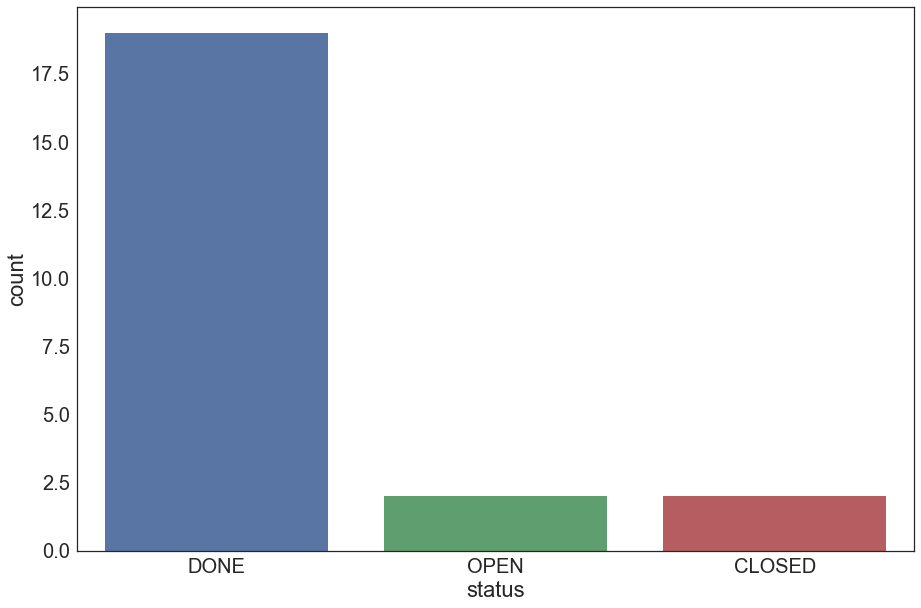

In [16]:
#Bar chart breaking down violations from single point by status. 

sns.set(font_scale = 2)
sns.set_style("white")
plt.subplots(figsize=(15,10))
sns.countplot(x = "status", data = same_lat)

In [17]:
#Folium map showing location of point with highest number of violations. 
#Lat lng from df placed it in the street. Had to copy address into google maps and then get lat lng from that.

map_1 = folium.Map(location=[36.051935, -86.714561], zoom_start=16)
folium.Marker([36.0520584, -86.71748639999998]).add_to(map_1)
map_1

The above data are nice but a bigger question is if there are any coorelations between violation categories. Many of the typical ways to measure coorelation require 2 variables but we have 3 variables: Lat, lng, and category. Two are continuous, one is categorical. I'm sure there are ways to do it but the only way I found after a brief search is the jaccard index. This takes two data sets (list, series, or df) creates a ratio of the intersection/union. Below are a few spot checks, not a full comparison of every combination.

In [18]:
innerWV = WASTE.merge(right = VEHICLE, how = "inner", on = ["lat", "lng"])
outerWV = WASTE.merge(right = VEHICLE, how = "outer", on = ["lat", "lng"])
JaccardWV = len(innerWV)/len(outerWV)
JaccardWV

0.4358891440028458

In [19]:
innerWL = WASTE.merge(right = LANDSCAPE, how = "inner", on = ["lat", "lng"])
outerWL = WASTE.merge(right = LANDSCAPE, how = "outer", on = ["lat", "lng"])
JaccardWL = len(innerWL)/len(outerWL)
JaccardWL

0.7089513556618819

In [20]:
innerVL = VEHICLE.merge(right = LANDSCAPE, how = "inner", on = ["lat", "lng"])
outerVL = VEHICLE.merge(right = LANDSCAPE, how = "outer", on = ["lat", "lng"])
JaccardVL = len(innerVL)/len(outerVL)
JaccardVL

0.5153598071472782

In [21]:
innerPE = PLUMBING.merge(right = ELECTRICAL, how = "inner", on = ["lat", "lng"])
outerPE = PLUMBING.merge(right = ELECTRICAL, how = "outer", on = ["lat", "lng"])
JaccardPE = len(innerPE)/len(outerPE)
JaccardPE

0.02097902097902098

In [22]:
innerExF = EXTBLD.merge(right = FENCING, how = "inner", on = ["lat", "lng"])
outerExF = EXTBLD.merge(right = FENCING, how = "outer", on = ["lat", "lng"])
JaccardExF = len(innerExF)/len(outerExF)
JaccardExF

0.015127388535031847

In [23]:
innerWS = WASTE.merge(right = SIGNAGE, how = "inner", on = ["lat", "lng"])
outerWS = WASTE.merge(right = SIGNAGE, how = "outer", on = ["lat", "lng"])
JaccardWS = len(innerWS)/len(outerWS)
JaccardWS

0.1336425258651445

These metrics are fine but I think it is swayed too much by number of points. Categories that have many points when compared will have much higher score than those with smaller numbers. Need to find a better way to compare and find correlation.

map violations by report type

In [24]:
categories_2["complaint_source"].value_counts()

INSPECTOR REPORTED                     13530
PHONE                                  11788
EMAIL                                   8483
Codes Online                             977
OTHER SOURCE                             324
SPE                                      162
WALK IN                                  111
NEIGHBORHOOD NOTIFICATION                109
Metro Council                             95
MAIL                                      44
COMMUNITY MATTERS                         35
Other Metro Agency                        33
NEIGHBORHOOD GROUP                        32
CAL                                       24
Metro PD                                  13
Metro Public Works                        10
INCIDENTS CONVERTED FROM OLD SYSTEM        4
RENT INSPECTION AUDIT                      3
Name: complaint_source, dtype: int64

In [25]:
#Create new dfs based on complaint source

INSPECTOR_REPORTED = categories_2[categories_2["complaint_source"].str.contains("INSPECTOR REPORTED", na = False)]
PHONE = categories_2[categories_2["complaint_source"].str.contains("PHONE", na = False)]
EMAIL = categories_2[categories_2["complaint_source"].str.contains("EMAIL", na = False)]
Codes_Online = categories_2[categories_2["complaint_source"].str.contains("Codes Online", na = False)]
OTHER_SOURCE = categories_2[categories_2["complaint_source"].str.contains("OTHER SOURCE", na = False)]
SPE = categories_2[categories_2["complaint_source"].str.contains("SPE", na = False)]
WALK_IN = categories_2[categories_2["complaint_source"].str.contains("WALK IN", na = False)]
NEIGHBORHOOD_NOTIFICATION = categories_2[categories_2["complaint_source"].str.contains("NEIGHBORHOOD NOTIFICATION", na = False)]
Metro_Council = categories_2[categories_2["complaint_source"].str.contains("Metro Council", na = False)]
MAIL = categories_2[categories_2["complaint_source"].str.contains("MAIL", na = False)]
COMMUNITY_MATTERS = categories_2[categories_2["complaint_source"].str.contains("COMMUNITY MATTERS", na = False)]
Other_Metro_Agency = categories_2[categories_2["complaint_source"].str.contains("Other Metro Agency", na = False)]
NEIGHBORHOOD_GROUP = categories_2[categories_2["complaint_source"].str.contains("NEIGHBORHOOD GROUP", na = False)]
CAL = categories_2[categories_2["complaint_source"].str.contains("CAL", na = False)]
Metro_PD = categories_2[categories_2["complaint_source"].str.contains("Metro PD", na = False)]
Metro_Public_Works = categories_2[categories_2["complaint_source"].str.contains("Metro Public Works", na = False)]
INCIDENTS_CONVERTED_FROM_OLD_SYSTEM = categories_2[categories_2["complaint_source"].str.contains("INCIDENTS CONVERTED FROM OLD SYSTEM", na = False)]
RENT_INSPECTION_AUDIT = categories_2[categories_2["complaint_source"].str.contains("RENT INSPECTION AUDIT", na = False)]

In [26]:
#Same plot as previous bokeh plot but this time points are grouped by complaint source. 
#Metro council and neighborhood notification appear to have some clustering.
#Some redundancy on complaint source, can be observed that there is complete overlap between some categories.

p1 = figure(plot_width=1000, plot_height=1000, title = "Property Standards Violations in Nashville by Complaint Source")

p1.xaxis.axis_label = "Longitude"
p1.yaxis.axis_label = "Latitude"

p1.patches('xs', 'ys', fill_alpha=0, source=geo_source, line_color = "black")

for data, name, color in zip([INSPECTOR_REPORTED, PHONE, EMAIL, Codes_Online, OTHER_SOURCE, SPE, WALK_IN, 
                              NEIGHBORHOOD_NOTIFICATION, Metro_Council, MAIL, COMMUNITY_MATTERS, Other_Metro_Agency, 
                              NEIGHBORHOOD_GROUP, CAL, Metro_PD, Metro_Public_Works, 
                              INCIDENTS_CONVERTED_FROM_OLD_SYSTEM, RENT_INSPECTION_AUDIT], 
                             ["INSPECTOR_REPORTED", "PHONE", "EMAIL", "Codes_Online", "OTHER_SOURCE", "SPE", "WALK_IN", 
                              "NEIGHBORHOOD_NOTIFICATION", "Metro_Council", "MAIL", "COMMUNITY_MATTERS", 
                              "Other_Metro_Agency", "NEIGHBORHOOD_GROUP", "CAL", "Metro_PD", "Metro_Public_Works", 
                              "INCIDENTS_CONVERTED_FROM_OLD_SYSTEM", "RENT_INSPECTION_AUDIT"], Category20_20):
    combined = pd.DataFrame(data)
    p1.circle(combined["lng"], combined["lat"], line_alpha = 0, color=color, size = 5, legend = name)

p1.legend.location = "top_right"
p1.legend.click_policy="hide"

show(p1)

Future Directions:

Make map more interactive. Add two datetime sliders that use JSCallbacks that filter the points shown by date. Two sliders will allow controlling the upper and lower boundaries for date. Range slider does not have interaction abilities right now.

Figure out how to predict where points are showing up. Train a model on lat lng to predict category.

Add street lines (geojson available but costs money) or overlay on real map (tried folium and iPyleaflet with geopandas but was too difficult to figure out. Bokeh can use google api but didn't bother setting it up. Be sure to use matching ESPG number, usually supplied with geojsons).

Add ability to filter by district. Best case scenario is to make polygons interactive but may also be able to do using checkboxes.